# SigPy for MRI Tutorial Part 1: Non Uniform Fast Fourier Transform (NUFFT)

Welcome!

In this notebook, we will go through basic features of SigPy using the NUFFT as an example usage. NUFFT is a core operation in non-Cartesian MRI, but still can be a computational bottleneck in many applications. We will show how you can easily change parameters and computing devices in SigPy to speed things up.

Before moving on to the tutorial, we want to point out our [documentation](https://sigpy.readthedocs.io) if you want to find out more information about each function.


## Setup
If you haven't installed SigPy already, please follow the [installation instructions](https://sigpy.readthedocs.io/en/latest/index.html#installation), and come back to this tutorial after.

SigPy is meant to use along with NumPy. In particular, SigPy operates on NumPy arrays directly, and relies on NumPy to provide basic data manipulation functions. Almost aways, we will import NumPy along with SigPy.

In addition to that, we will import the [sigpy.plot](https://sigpy.readthedocs.io/en/latest/plot.html) sub-module for plotting. The module provides convenient plotting functions for multi-dimensional arrays, using only hot-keys for control. We will be using them to show images, but not focus them in this tutorial.

Finally, the `%matplotlib notebook` magic allows us to get interactive plots in jupyter notebooks.

In [1]:
%matplotlib notebook
import numpy as np
import sigpy as sp
import sigpy.plot as pl

We will use a non-Cartesian dataset created by Prof. Martin Uecker for the [ISMRM reproducible challenge](https://blog.ismrm.org/2019/04/02/ismrm-reproducible-research-study-group-2019-reproduce-a-seminal-paper-initiative/). The dataset contains k-space measurements of a brain scan acquired with a projection reconstruction trajectory. We have re-saved the dataset into NumPy data format. Let us load the dataset and look at the array shapes.

In [2]:
ksp = np.load('data/radial_ksp.npy')
coord = np.load('data/radial_coord.npy')

print('k-space array shape: {}'.format(ksp.shape))
print('coordinate array shape: {}'.format(coord.shape))

k-space array shape: (12, 96, 512)
coordinate array shape: (96, 512, 2)


A few words about array shapes. Because NumPy by default stores arrays by row-major, the array shapes are flipped compared to what you would expect in Matlab or Fortran, which uses column-major. The k-space array has its shape arranged as number of coil channels, number of repetitions, and number of readout points. The coordinate array has its shape arranged as number of repetitions, number of readout points and number of dimensions. In this case, you can see this is a 2D dataset, because the last dimension of `coord` is 2.

## Gridding Reconstruction

For gridding reconstruction, we will need the density compensation factor (`dcf`). For the projection reconstruction trajectory, it is proportional to the radius of the k-space coordinates. 

Let us compute the density compensation factor and visualize it with the function [ScatterPlot](https://sigpy.readthedocs.io/en/latest/generated/sigpy.plot.ScatterPlot.html#sigpy.plot.ScatterPlot).

<IPython.core.display.Javascript object>


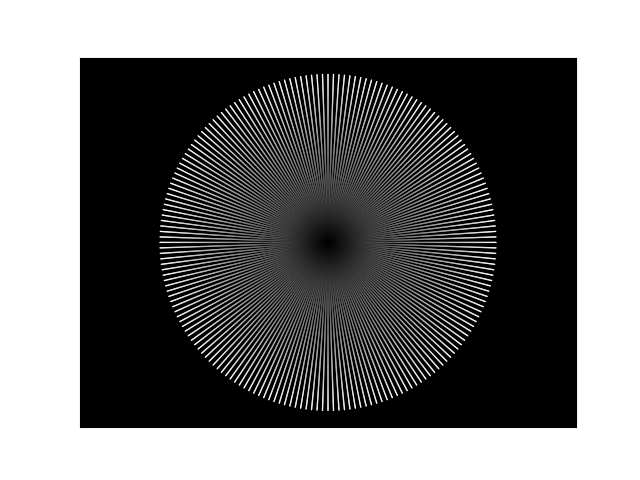

In [3]:
dcf = (coord[..., 0]**2 + coord[..., 1]**2)**0.5
pl.ScatterPlot(coord, dcf, hide_axes=True)

The imported arrays are NumPy arrays, so SigPy can operate on them directly. To perform an gridding reconstruction, we can simply call [nufft_adjoint](https://sigpy.readthedocs.io/en/latest/generated/sigpy.nufft_adjoint.html#sigpy.nufft_adjoint) on the density compensated input `ksp * dcf`. This gives us the gridded multi-channel images:

<IPython.core.display.Javascript object>


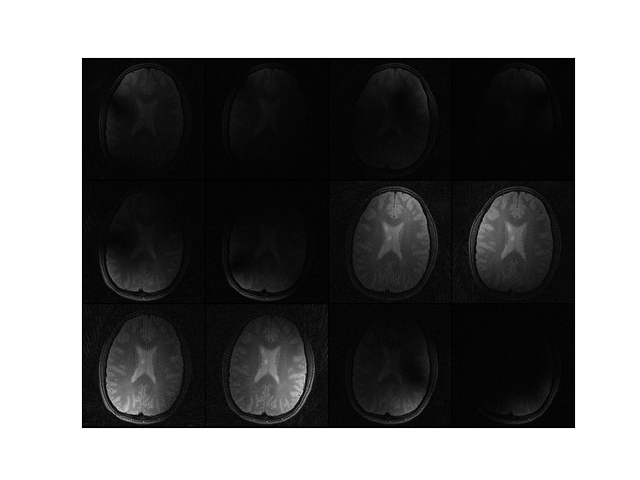

In [5]:
img_grid = sp.nufft_adjoint(ksp * dcf, coord)
pl.ImagePlot(img_grid, z=0, hide_axes=True)

We will combine the coil images by performing root-sum-of-squares along the coil dimension. This can be easily done using NumPy operations.

<IPython.core.display.Javascript object>


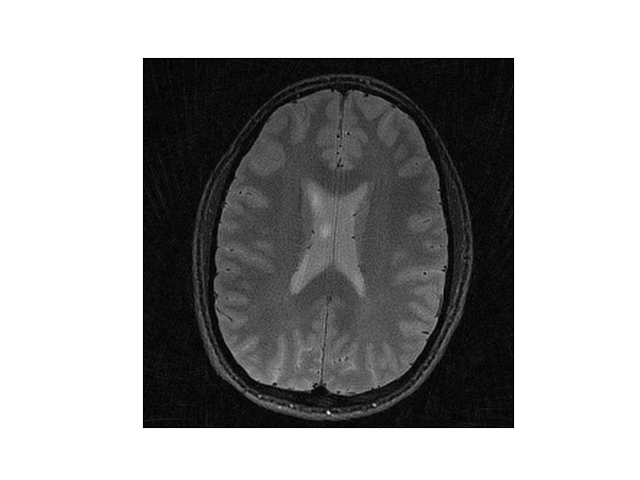

In [6]:
img_rss = np.sum(np.abs(img_grid)**2, axis=0)**0.5
pl.ImagePlot(img_rss, hide_axes=True)

The gridding reconstruction isn't too slow, but perhaps we might want it to be faster when we have a stack of images. One way we can make the reconstruction faster is tuning the oversampling ratios and kernel widths of [nufft_adjoint](https://sigpy.readthedocs.io/en/latest/generated/sigpy.nufft_adjoint.html#sigpy.nufft_adjoint).

We will prepend the magic command `% time` to the nufft_adjoint call to time it. Change the nufft parameters and see how they affect the run-time and artifacts!

CPU times: user 882 ms, sys: 6.86 ms, total: 889 ms
Wall time: 73.5 ms


<IPython.core.display.Javascript object>


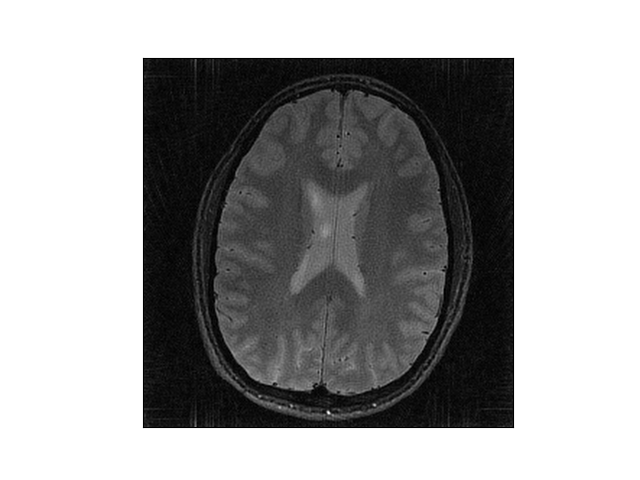

In [7]:
%time img_grid_tune = sp.nufft_adjoint(ksp * dcf, coord, oversamp=1, width=2)

img_rss_tune = np.sum(np.abs(img_grid_tune)**2, axis=0)**0.5
pl.ImagePlot(img_rss_tune, hide_axes=True)

## Gridding Reconstruction on GPU

SigPy allows you 

To run the NUFFT on GPU, all we have to do is to move the arrays to a GPU device, and wrap the function with a GPU device context. This is similar to how Tensorflow or Pytorch specify their computing device.

![device](https://sigpy.readthedocs.io/en/latest/_images/device.pdf)

In order to run the following code, you will need to have a GPU, and install the package `cupy`.

<IPython.core.display.Javascript object>


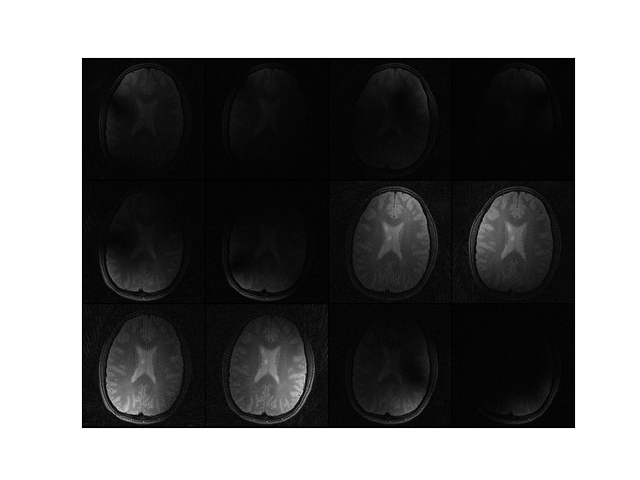

In [9]:
device = sp.Device(0)

ksp_gpu = sp.to_device(ksp, device=device)
coord_gpu = sp.to_device(coord, device=device)
dcf_gpu = sp.to_device(dcf, device=device)

with device:
    img_grid_gpu = sp.nufft_adjoint(ksp_gpu * dcf_gpu, coord_gpu)

pl.ImagePlot(img_grid_gpu, z=0, hide_axes=True)

<IPython.core.display.Javascript object>


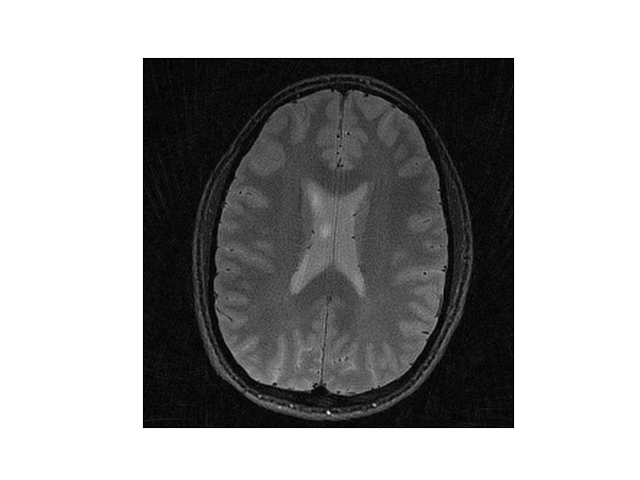

In [10]:
xp = device.xp
with device:
    img_rss_gpu = xp.sum(xp.abs(img_grid_gpu)**2, axis=0)**0.5

pl.ImagePlot(img_rss_gpu, hide_axes=True)

In [6]:
import sigpy.mri as mr

mps = mr.app.JsenseRecon(ksp, coord=coord).run()

LinearLeastSquares: 100%|██████████| 10/10 [00:00<00:00, 38.69it/s, resid=4.57E-01]


LinearLeastSquares: 100%|██████████| 10/10 [00:00<00:00, 30.07it/s, resid=4.25E-03]

LinearLeastSquares: 100%|██████████| 10/10 [00:00<00:00, 31.37it/s, resid=2.73E-01]


LinearLeastSquares: 100%|██████████| 10/10 [00:00<00:00, 31.29it/s, resid=1.61E-01]


LinearLeastSquares: 100%|██████████| 10/10 [00:00<00:00, 28.11it/s, resid=1.60E-03]

LinearLeastSquares: 100%|██████████| 10/10 [00:00<00:00, 35.05it/s, resid=1.31E-01]


LinearLeastSquares:  90%|█████████ | 9/10 [00:00<00:00, 33.97it/s, resid=1.16E-01]


JsenseRecon: 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]98it/s, resid=1.16E-01]


<IPython.core.display.Javascript object>


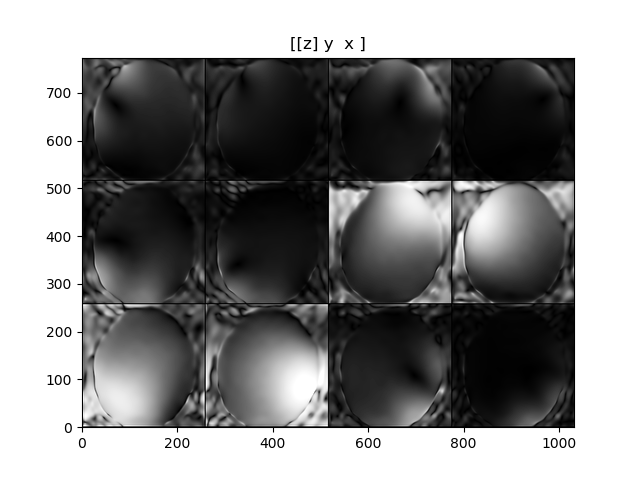

In [7]:
pl.ImagePlot(mps)

In [26]:
lamda = 1e-6
img = mr.app.L1WaveletRecon(ksp, mps, coord=coord, lamda=lamda, device=0).run()


MaxEig: 100%|██████████| 30/30 [00:00<00:00, 45.17it/s, max_eig=1.28E+02]

L1WaveletRecon:  15%|█▌        | 15/100 [00:00<00:03, 22.30it/s, resid=6.64E-03]


L1WaveletRecon:  57%|█████▋    | 57/100 [00:02<00:01, 22.00it/s, resid=1.17E-03]


L1WaveletRecon:  98%|█████████▊| 98/100 [00:04<00:00, 21.28it/s, resid=4.75E-04]


L1WaveletRecon: 100%|██████████| 100/100 [00:04<00:00, 23.13it/s, resid=4.67E-04]


<IPython.core.display.Javascript object>


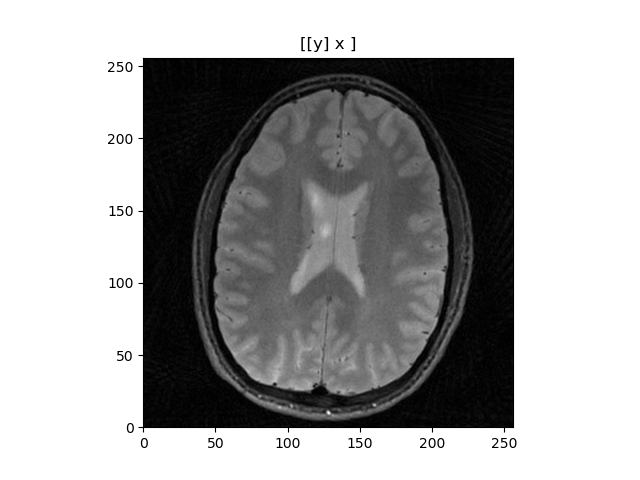

In [27]:
pl.ImagePlot(img)